# Climate-fact-checker


# 1.DataSet Processing

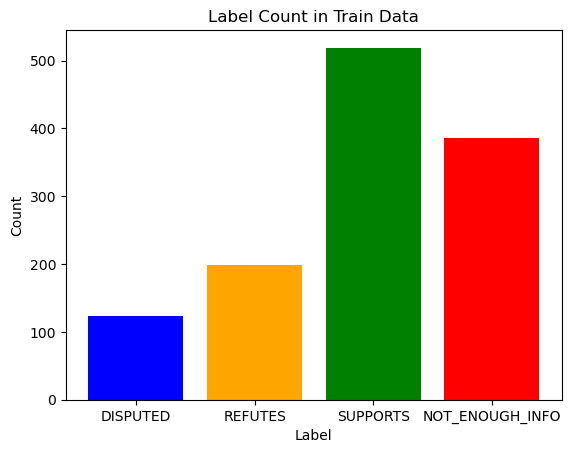

In [ ]:
# Analysis of train-claims.json
import json
from collections import Counter
import matplotlib.pyplot as plt

# Load train data
with open('data/train-claims.json', 'r') as f:
    train_claims_dict = json.load(f)

# Extract labels from train data
labels = [claim_info['claim_label'] for claim_info in train_claims_dict.values()]

# Count the occurrences of each label
label_counts = Counter(labels)

# Define colors for each label
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plot the label count with different colors for each bar
plt.bar(label_counts.keys(), label_counts.values(), color=colors[:len(label_counts)])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count in Train Data')
plt.show()


In [ ]:
# Basic data handling and mathematical libraries
import json
import numpy as np
import random
import pickle

# NLP-related libraries
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity


# PyTorch related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization library
import matplotlib.pyplot as plt

# Gensim for model loading (Word2Vec)
from gensim.models import Word2Vec

# Dimensionality reduction and data splitting
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# Other utilities
from collections import defaultdict

# NLTK resource downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


analysis of evidence.json

In [3]:
import json
import re
import string

def is_english(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

# Read the JSON file
with open('data/evidence.json', 'r') as file:
    document_content = json.load(file)

evidence_list = list(document_content.values())
total_evidence = len(evidence_list)

# filter out english evidence 
english_evidence = [ev for ev in evidence_list if is_english(ev)]
num_english_evidence = len(english_evidence)

print(f"Total number of evidence: {total_evidence}")
print(f"Number of English evidence: {num_english_evidence}")


Total number of evidence: 1208827
Number of English evidence: 1103245


remove the evidence that is not related to climate science
1. Topic modeling is a technique that identifies topics or themes present in a collection of documents. We can use a topic modeling algorithm like Latent Dirichlet Allocation (LDA) to identify the documents (evidence) that are relevant to climate science.
2. Keyword Filtering
Alternatively, we can use a list of keywords related to climate science and filter out the evidence texts that do not contain any of these keywords.


In [ ]:
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS

# Lowercase all words in english_evidence
english_evidence_lower = [ev.lower() for ev in english_evidence]

# Add additional stopwords
additional_stopwords = set([";", "'s", "--", ":", "|", "'", "-", "`"])
STOPWORDS = STOPWORDS.union(additional_stopwords)

# Create a dictionary from the lowercase evidence texts, removing stopwords
dictionary = corpora.Dictionary([ev.split() for ev in english_evidence_lower])
stop_ids = [dictionary.token2id[stopword] for stopword in STOPWORDS if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)
dictionary.compactify()

# Create a corpus of bag-of-words vectors
corpus = [dictionary.doc2bow(ev.split()) for ev in english_evidence_lower]

Choosing the right number of topics (num_topics) 
start with a smaller number of topics and gradually increase it while evaluating the coherence of the topics. Coherence measures how interpretable the topics are based on the co-occurrence of words within the topics.  use coherence as a guide to find the optimal num_topics.

In [ ]:
from gensim.models import CoherenceModel

# Define a range of candidate numbers of topics
num_topics_range = range(5, 50, 5)

# Compute coherence scores for each number of topics
coherence_scores = []
for num_topics in num_topics_range:
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, texts=english_evidence_lower, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]

print(f"Optimal number of topics: {optimal_num_topics}")

In [ ]:
# Train the LDA model
lda_model_5topic = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5)

# Print the top words for each topic
for topic_id in range(lda_model_5topic.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))

Topic 0:
0.009*"parliament" + 0.008*"battle" + 0.006*"member" + 0.005*"21" + 0.005*"medals" + 0.005*"passed" + 0.004*"united" + 0.004*"web" + 0.004*"1978" + 0.004*"paris"
Topic 1:
0.011*"#" + 0.010*"music" + 0.008*"contains" + 0.008*"successful" + 0.007*"festival" + 0.007*"australia." + 0.007*"island" + 0.006*"endemic" + 0.006*"course" + 0.006*"classical"
Topic 2:
0.012*"composed" + 0.012*"commonly" + 0.009*"man" + 0.009*"referred" + 0.008*"japan." + 0.006*"leaves" + 0.005*"chemical" + 0.005*"theater" + 0.005*"years." + 0.005*"got"
Topic 3:
0.057*"(born" + 0.036*"american" + 0.031*"football" + 0.015*"australian" + 0.014*"player" + 0.013*"professional" + 0.012*"played" + 0.010*"footballer" + 0.010*"plays" + 0.010*"december"
Topic 4:
0.023*"new" + 0.012*"married" + 0.009*"son" + 0.008*"brother" + 0.008*"governor" + 0.007*"father" + 0.007*"2013." + 0.007*"wife" + 0.007*"mount" + 0.007*"film"


In [ ]:
# Train the LDA model
lda_model_10topic = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10)

# Print the top words for each topic
for topic_id in range(lda_model_10topic.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))


Topic 0:
0.009*"parliament" + 0.008*"battle" + 0.006*"member" + 0.005*"21" + 0.005*"medals" + 0.005*"passed" + 0.004*"united" + 0.004*"web" + 0.004*"1978" + 0.004*"paris"
Topic 1:
0.011*"#" + 0.010*"music" + 0.008*"contains" + 0.008*"successful" + 0.007*"festival" + 0.007*"australia." + 0.007*"island" + 0.006*"endemic" + 0.006*"course" + 0.006*"classical"
Topic 2:
0.012*"composed" + 0.012*"commonly" + 0.009*"man" + 0.009*"referred" + 0.008*"japan." + 0.006*"leaves" + 0.005*"chemical" + 0.005*"theater" + 0.005*"years." + 0.005*"got"
Topic 3:
0.057*"(born" + 0.036*"american" + 0.031*"football" + 0.015*"australian" + 0.014*"player" + 0.013*"professional" + 0.012*"played" + 0.010*"footballer" + 0.010*"plays" + 0.010*"december"
Topic 4:
0.023*"new" + 0.012*"married" + 0.009*"son" + 0.008*"brother" + 0.008*"governor" + 0.007*"father" + 0.007*"2013." + 0.007*"wife" + 0.007*"mount" + 0.007*"film"
Topic 5:
0.017*"air" + 0.013*"force" + 0.013*"climate" + 0.010*"change" + 0.008*"nuclear" + 0.008*

In [ ]:
# Train the LDA model
lda_model_15topic = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics= 15)

# Print the top words for each topic
for topic_id in range(lda_model_15topic.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))

Topic 0:
0.009*"parliament" + 0.008*"battle" + 0.006*"member" + 0.005*"21" + 0.005*"medals" + 0.005*"passed" + 0.004*"united" + 0.004*"web" + 0.004*"1978" + 0.004*"paris"
Topic 1:
0.011*"#" + 0.010*"music" + 0.008*"contains" + 0.008*"successful" + 0.007*"festival" + 0.007*"australia." + 0.007*"island" + 0.006*"endemic" + 0.006*"course" + 0.006*"classical"
Topic 2:
0.012*"composed" + 0.012*"commonly" + 0.009*"man" + 0.009*"referred" + 0.008*"japan." + 0.006*"leaves" + 0.005*"chemical" + 0.005*"theater" + 0.005*"years." + 0.005*"got"
Topic 3:
0.057*"(born" + 0.036*"american" + 0.031*"football" + 0.015*"australian" + 0.014*"player" + 0.013*"professional" + 0.012*"played" + 0.010*"footballer" + 0.010*"plays" + 0.010*"december"
Topic 4:
0.023*"new" + 0.012*"married" + 0.009*"son" + 0.008*"brother" + 0.008*"governor" + 0.007*"father" + 0.007*"2013." + 0.007*"wife" + 0.007*"mount" + 0.007*"film"
Topic 5:
0.017*"air" + 0.013*"force" + 0.013*"climate" + 0.010*"change" + 0.008*"nuclear" + 0.008*

In [ ]:
# Train the LDA model
lda_model_20topic = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics= 20)

# Print the top words for each topic
for topic_id in range(lda_model_20topic.num_topics):
    print(f"Topic {topic_id}:")
    print(lda_model.print_topic(topic_id))

Topic 0:
0.009*"parliament" + 0.008*"battle" + 0.006*"member" + 0.005*"21" + 0.005*"medals" + 0.005*"passed" + 0.004*"united" + 0.004*"web" + 0.004*"1978" + 0.004*"paris"
Topic 1:
0.011*"#" + 0.010*"music" + 0.008*"contains" + 0.008*"successful" + 0.007*"festival" + 0.007*"australia." + 0.007*"island" + 0.006*"endemic" + 0.006*"course" + 0.006*"classical"
Topic 2:
0.012*"composed" + 0.012*"commonly" + 0.009*"man" + 0.009*"referred" + 0.008*"japan." + 0.006*"leaves" + 0.005*"chemical" + 0.005*"theater" + 0.005*"years." + 0.005*"got"
Topic 3:
0.057*"(born" + 0.036*"american" + 0.031*"football" + 0.015*"australian" + 0.014*"player" + 0.013*"professional" + 0.012*"played" + 0.010*"footballer" + 0.010*"plays" + 0.010*"december"
Topic 4:
0.023*"new" + 0.012*"married" + 0.009*"son" + 0.008*"brother" + 0.008*"governor" + 0.007*"father" + 0.007*"2013." + 0.007*"wife" + 0.007*"mount" + 0.007*"film"
Topic 5:
0.017*"air" + 0.013*"force" + 0.013*"climate" + 0.010*"change" + 0.008*"nuclear" + 0.008*

In [ ]:
# Filter out the evidence related to climate science
# Topic ID representing climate science (you may need to inspect the topics)
climate_topic_id = 2  
climate_evidence_topic_modelling = [ev for ev, topic_vector in zip(english_evidence, lda_model_10topic[corpus]) if climate_topic_id in [topic_id for topic_id, score in topic_vector]]

print(len(climate_evidence_topic_modelling))
print(climate_evidence_topic_modelling[:10])

729649
['John Bennet Lawes, English entrepreneur and agricultural scientist', "``Boston (Ladies of Cambridge)'' by Vampire Weekend", 'He detected abnormalities of oxytocinergic function in schizoaffective mania, post-partum psychosis and how ECT modified oxytocin release.', 'He is currently a professor of piano at the University of Wisconsin -- Madison since August 2000.', 'Matroid duals go back to the original paper by Hassler Whitney defining matroids.', 'He is the current AIDA Individual World Champion Constant Weight (September 2005).', 'When employees click on something in their computers, the criminals get access to the computers.', 'He is best known as author of The Prize : The Epic Quest for Oil, Money, and Power (1991) and The Quest : Energy, Security, and the Remaking of the Modern World (2011).', 'Formally, Contact Improvisation is a movement improvisation mainly explored in duets.', 'It did not chart in the United States, despite receiving airplay in several markets.']


In [6]:
# Read dataset
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


train_claims = read_dataset("data/train-claims.json")
dev_claims = read_dataset("data/dev-claims.json")
test_claims = read_dataset("data/test-claims-unlabelled.json")
evidences = read_dataset("data/evidence.json")

# Text preprocessing function
def preprocess_text(text):
    # Tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Preprocess all files
preprocessed_evidences = {id: preprocess_text(evidence) for id, evidence in evidences.items()}
preprocessed_train_claims = {id: preprocess_text(claim['claim_text']) for id, claim in train_claims.items()}
preprocessed_dev_claims = {id: preprocess_text(claim['claim_text']) for id, claim in dev_claims.items()}
preprocessed_test_claims = {id: preprocess_text(claim['claim_text']) for id, claim in test_claims.items()}


# Save preprocessed data
with open("preprocessed_test_claims.json", 'w') as file:
    json.dump(preprocessed_test_claims, file)

with open("preprocessed_dev_claims.json", 'w') as file:
    json.dump(preprocessed_dev_claims, file)

with open("preprocessed_train_claims.json", 'w') as file:
    json.dump(preprocessed_train_claims, file)

with open("preprocessed_evidences.json", 'w') as file:
    json.dump(preprocessed_evidences, file)

# Read the preprocessed data
with open("preprocessed_test_claims.json", 'r') as file:
    preprocessed_test_claims = json.load(file)

with open("preprocessed_dev_claims.json", 'r') as file:
    preprocessed_dev_claims = json.load(file)

with open("preprocessed_train_claims.json", 'r') as file:
    preprocessed_train_claims = json.load(file)

with open("preprocessed_evidences.json", 'r') as file:
    preprocessed_evidences = json.load(file)


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import json

## top 100 evidence 
class CustomTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, doc_ids):
        # Store document IDs in a list to ensure they are subscriptable
        self.doc_ids = list(doc_ids)
        return super().fit_transform(list(raw_documents))

# Vectorize the evidence texts
vectorizer = CustomTfidfVectorizer(max_features=800000)
evidences_vectors = vectorizer.fit_transform(preprocessed_evidences.values(), preprocessed_evidences.keys())
dev_claims_vectors = vectorizer.transform(preprocessed_dev_claims.values())

print("Shape of evidence vectors:", evidences_vectors.shape)
print("Shape of dev claim vectors:", dev_claims_vectors.shape)

def filter_top_evidences(claim_data, evidences_data, claim_vectors, evidences_vectors, top_k):
    similarities = cosine_similarity(claim_vectors, evidences_vectors)
    top_indices = np.argsort(-similarities)[:, :top_k]
    result = []
    for claim_id, indices in zip(claim_data.keys(), top_indices):
        claim_text = claim_data[claim_id]
        for idx in indices:
            evidence_id = list(evidences_data.keys())[idx]
            evidence_text = evidences_data[evidence_id]
            result.append({
                'claim_id': claim_id,
                'claim_text': claim_text,
                'evidence_id': evidence_id,
                'evidence_text': evidence_text
            })
    return result

top_k = 100  # Number of top evidences to retrieve

# Filter top evidences for dev claims
dev_top_evidence_records = filter_top_evidences(preprocessed_dev_claims, preprocessed_evidences, dev_claims_vectors, evidences_vectors, top_k)

def save_evidence_records(evidence_records, file_path):
    # Save the evidence records to a JSON file
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(evidence_records, f, ensure_ascii=False, indent=4)

# Save the filtered evidence records
save_evidence_records(dev_top_evidence_records, 'data/100_dev_top_evidence_records.json')


Shape of evidence vectors: (1208827, 591318)
Shape of dev claim vectors: (154, 591318)


In [ ]:
class CustomTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, doc_ids):
        self.doc_ids = doc_ids
        return super().fit_transform(raw_documents)


# Convert the evidence corpus into a TF-IDF matrix and limit its size; optional topic-based filtering can be applied here
vectorizer = CustomTfidfVectorizer(max_features=800000)
evidences_vectors = vectorizer.fit_transform(preprocessed_evidences.values(), preprocessed_evidences.keys())
train_claims_vectors = vectorizer.transform(preprocessed_train_claims.values())
dev_claims_vectors = vectorizer.transform(preprocessed_dev_claims.values())
test_claims_vectors = vectorizer.transform(preprocessed_test_claims.values())

# Display the shape of the TF-IDF matrix (number of documents × number of features)
print("Shape of evidence:", evidences_vectors.shape)
print("Shape of train:", train_claims_vectors.shape)
print("Shape of dev:", dev_claims_vectors.shape)
print("Shape of test:", test_claims_vectors.shape)

keys = list(vectorizer.doc_ids)

def filter_evidences_by_threshold(claim_vectors, evidences_vectors, doc_ids, threshold):
    similarities = cosine_similarity(claim_vectors, evidences_vectors)
    max_similarities = np.max(similarities, axis=0)
    filtered_indices = np.where(max_similarities >= threshold)[0]
    filtered_doc_ids = [list(doc_ids)[i] for i in filtered_indices]
    return filtered_doc_ids

threshold = 0.2

# Retrieve all evidence document IDs from the evidence corpus
evidence_doc_ids = vectorizer.doc_ids

# Perform evidence filtering for each claim in the training set
train_filtered_evidence_ids = filter_evidences_by_threshold(train_claims_vectors, evidences_vectors, evidence_doc_ids, threshold)

Shape of evidence: (1208827, 591318)
Shape of train: (1228, 591318)
Shape of dev: (154, 591318)
Shape of test: (153, 591318)


KeyboardInterrupt: 

In [ ]:
# Extract negative examples for preparing the dataset
candidate_negatives = {}
for evidence_id, evidence_text in evidences.items():
    if evidence_id not in train_filtered_evidence_ids:
        candidate_negatives[evidence_id] = evidence_text

positive_evidence_ids = set()

for claim_id, claim_data in train_claims.items():
    positive_evidence_ids.update(claim_data['evidences'])

filtered_candidate_negatives = {}
for evidence_id, evidence_text in candidate_negatives.items():
    if evidence_id not in positive_evidence_ids:
        filtered_candidate_negatives[evidence_id] = evidence_text

# Save candidate_negatives to a local file
with open('candidate_negatives.pkl', 'wb') as f:
    pickle.dump(candidate_negatives, f)

# Save filtered_candidate_negatives to a local file
with open('filtered_candidate_negatives.pkl', 'wb') as f:
    pickle.dump(filtered_candidate_negatives, f)

print("Objects saved successfully!")

# Load the candidate_negatives object
with open('candidate_negatives.pkl', 'rb') as f:
    candidate_negatives = pickle.load(f)

# Load the filtered_candidate_negatives object
with open('filtered_candidate_negatives.pkl', 'rb') as f:
    filtered_candidate_negatives = pickle.load(f)

print("Objects loaded successfully!")

# Print the object length to verify it was loaded correctly
print(f"Length of candidate_negatives: {len(candidate_negatives)}")
print(f"Length of filtered_candidate_negatives: {len(filtered_candidate_negatives)}")

In [ ]:
# Build train dataset with positives and negatives

with open('candidate_negatives.pkl', 'rb') as f:
    candidate_negatives = pickle.load(f)

# Build training dataset containing positive and negative examples
postive_negatives_train_data = []
for claim_id, claim_data in train_claims.items():
    claim_text = claim_data['claim_text']
    positive_evidences = claim_data['evidences']
    negative_evidences = random.sample(list(candidate_negatives.keys()), len(positive_evidences))

    # Build positive samples
    for evidence_id in positive_evidences:
        postive_negatives_train_data.append({
            'claim_id': claim_id,
            'claim_text': claim_text,
            'evidence_id': evidence_id,
            'evidence_text': evidences[evidence_id],
            'label': 1
        })

    # Build negative samples
    for evidence_id in negative_evidences:
        postive_negatives_train_data.append({
            'claim_id': claim_id,
            'claim_text': claim_text,
            'evidence_id': evidence_id,
            'evidence_text': candidate_negatives[evidence_id],
            'label': 0
        })

# Save training dataset with positives and negatives
with open('postive_negatives_train_data.pkl', 'wb') as f:
    pickle.dump(postive_negatives_train_data, f)

print("Training data with negatives saved successfully!")

In [ ]:
# Read data
with open('postive_negatives_train_data.pkl', 'rb') as f:
    postive_negatives_train_data = pickle.load(f)
    
print("train data with negative: ",len(postive_negatives_train_data))
print(postive_negatives_train_data[:1])



In [ ]:

# Only training set
#train word2vc
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # lowercase
    tokens = word_tokenize(text)  # tokenize
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]  # remove non-alphabetic characters and short words
    stop_words = set(stopwords.words('english'))  # stopwords
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    lemmatizer = WordNetLemmatizer()  # lemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Function to generate separate sentences for claims and evidences
def get_sentences_word2vec(data):
    sentences = []
    for item in data:
        claim_tokens = preprocess_text(item['claim_text'])
        evidence_tokens = preprocess_text(item['evidence_text'])
        sentences.append(claim_tokens)  # Add claim as a separate sentence
        sentences.append(evidence_tokens)  # Add evidence as a separate sentence
    return sentences

# Get sentences
sentences_negatives = get_sentences_word2vec(postive_negatives_train_data)

# Training and saving Word2Vec models
from gensim.models import Word2Vec
# tunning the parameters
def train_word2vec(sentences, vector_size, window=5, min_count=2, workers=4, epochs=20):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    model.train(sentences, total_examples=len(sentences), epochs=epochs)
    return model


model_negatives = train_word2vec(sentences_negatives, vector_size=900)

# Save models
model_negatives.save('word2vec_model_positives_negatives.model')


In [ ]:

# Performance on the training set
# Checking Sentences Similarities
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

model = Word2Vec.load('word2vec_model_positives_negatives.model')

def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if words:
        return np.mean([model.wv[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)

def compare_sentences(sentence1, sentence2, model):
    vector1 = sentence_vector(sentence1, model)
    vector2 = sentence_vector(sentence2, model)
    similarity = 1 - cosine(vector1, vector2)  # Cosine similarity
    return similarity


# Checking the performance on the whole training data
b = []
error_samples = []
correct_samples = []
true_labels = []
pred_labels = []

#postive_negatives_train_data
for item in postive_negatives_train_data:
    claim_text = item['claim_text']
    evidence_text = item['evidence_text']
    claim_tokens = preprocess_text(claim_text)
    evidence_tokens = preprocess_text(evidence_text)
    label = item['label']

    similarity = compare_sentences(claim_tokens, evidence_tokens, model)

    # Check if the predicted label matches the original label
    predicted_label = 1 if similarity >= 0.4 else 0  # Adjust the threshold as needed
    if predicted_label != label:
        error_samples.append((claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, label, predicted_label))
    else:
        correct_samples.append((claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, label, predicted_label))

    true_labels.append(label)
    pred_labels.append(predicted_label)
    b.append((claim_tokens, evidence_tokens, label, similarity, predicted_label))

print("===========================Error cases:===========================")
print(f"Total errors: {len(error_samples)}")
for claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, original_label, predicted_label in error_samples[:3]:
    print("Original claim:", claim_text)
    print("Preprocessed claim:", claim_tokens)
    print("Original evidence:", evidence_text)
    print("Preprocessed evidence:", evidence_tokens)
    print(f"Similarity: {similarity:.4f}")
    print(f"Predicted Label: {predicted_label}")
    print()  # Print a blank line for separation

print("\n===========================Correct cases:===========================")
for claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, original_label, predicted_label in correct_samples[:3]:
    print("Original claim:", claim_text)
    print("Preprocessed claim:", claim_tokens)
    print("Original evidence:", evidence_text)
    print("Preprocessed evidence:", evidence_tokens)
    print(f"Similarity: {similarity:.4f}")
    print(f"Predicted Label: {predicted_label}")
    print()  # Print a blank line for separation

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:

def read_dataset(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

dev_claims = read_dataset("data/dev-claims.json")

def compute_average_f_score(finded, dev_claims=dev_claims):
    # Function to calculate precision, recall, and F-score
    def calculate_f_score(retrieved_evidences, ground_truth_evidences):
        retrieved_evidences_set = set(retrieved_evidences)
        ground_truth_evidences_set = set(ground_truth_evidences)
        
        true_positives = retrieved_evidences_set.intersection(ground_truth_evidences_set)
        precision = len(true_positives) / len(retrieved_evidences_set) if retrieved_evidences_set else 0
        recall = len(true_positives) / len(ground_truth_evidences_set) if ground_truth_evidences_set else 0
        
        if precision + recall != 0:
            f_score = 2 * precision * recall / (precision + recall)
        else:
            f_score = 0
        
        return precision, recall, f_score

    # Mapping retrieved evidences by claim from provided records
    retrieved_by_claim = {}
    for record in finded:
        if record['claim_id'] not in retrieved_by_claim:
            retrieved_by_claim[record['claim_id']] = []
        retrieved_by_claim[record['claim_id']].append(record['evidence_id'])

    # Calculate F-score for each claim
    f_scores = []
    for claim_id, details in dev_claims.items():
        retrieved_evidences = retrieved_by_claim.get(claim_id, [])
        ground_truth_evidences = details['evidences']
        _, _, f_score = calculate_f_score(retrieved_evidences, ground_truth_evidences)
        f_scores.append(f_score)

    # Average F-score across all claims
    average_f_score = sum(f_scores) / len(f_scores) if f_scores else 0
    return average_f_score


In [ ]:

# Performance on the development set
# Checking Sentences Similarities
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

model = Word2Vec.load('word2vec_model_positives_negatives.model')

def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if words:
        return np.mean([model.wv[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)

def compare_sentences(sentence1, sentence2, model):
    vector1 = sentence_vector(sentence1, model)
    vector2 = sentence_vector(sentence2, model)
    similarity = 1 - cosine(vector1, vector2)  # Cosine similarity
    return similarity


# Checking the performance on the whole training data
b = []
error_samples = []
correct_samples = []
true_labels = []
pred_labels = []

with open('data/100_withlabel_dev_top_evidence_records.json', 'r', encoding='utf-8') as file:
    dev_100_withlabel_dev_top_evidence_records = json.load(file)

for item in dev_100_withlabel_dev_top_evidence_records:
    claim_text = item['claim_text']
    evidence_text = item['evidence_text']
    claim_tokens = preprocess_text(claim_text)
    evidence_tokens = preprocess_text(evidence_text)
    label = item['label']

    similarity = compare_sentences(claim_tokens, evidence_tokens, model)

    # Check if the predicted label matches the original label
    predicted_label = 1 if similarity >= 0.5 else 0  # Adjust the threshold as needed
    if predicted_label != label:
        error_samples.append((claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, label, predicted_label))
    else:
        correct_samples.append((claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, label, predicted_label))

    true_labels.append(label)
    pred_labels.append(predicted_label)
    b.append((claim_tokens, evidence_tokens, label, similarity, predicted_label))

print("===========================Error cases:===========================")
print(f"Total errors: {len(error_samples)}")
for claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, original_label, predicted_label in error_samples[:3]:
    print("Original claim:", claim_text)
    print("Preprocessed claim:", claim_tokens)
    print("Original evidence:", evidence_text)
    print("Preprocessed evidence:", evidence_tokens)
    print(f"Similarity: {similarity:.4f}")
    print(f"Predicted Label: {predicted_label}")
    print()  # Print a blank line for separation

print("\n===========================Correct cases:===========================")
for claim_text, claim_tokens, evidence_text, evidence_tokens, similarity, original_label, predicted_label in correct_samples[:3]:
    print("Original claim:", claim_text)
    print("Preprocessed claim:", claim_tokens)
    print("Original evidence:", evidence_text)
    print("Preprocessed evidence:", evidence_tokens)
    print(f"Similarity: {similarity:.4f}")
    print(f"Predicted Label: {predicted_label}")
    print()  # Print a blank line for separation

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
# Use the above model to retrieve top-3 similar evidence passages and save in the required format
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import numpy as np

model = Word2Vec.load('word2vec_model_positives_negatives.model')
def sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv.key_to_index]
    if words:
        return np.mean([model.wv[word] for word in words], axis=0)
    else:
        return np.zeros(model.vector_size)

def compare_sentences(sentence1, sentence2, model):
    vector1 = sentence_vector(sentence1, model)
    vector2 = sentence_vector(sentence2, model)
    similarity = 1 - cosine(vector1, vector2)  # Cosine similarity
    return similarity

# Store all evidences with similarities for each claim
claim_evidences = {}

for item in dev_100_withlabel_dev_top_evidence_records:
    claim_id = item['claim_id']
    claim_text = item['claim_text']
    evidence_text = item['evidence_text']
    label = item['label']
    claim_tokens = preprocess_text(claim_text)
    evidence_tokens = preprocess_text(evidence_text)

    similarity = compare_sentences(claim_tokens, evidence_tokens, model)

    if claim_id not in claim_evidences:
        claim_evidences[claim_id] = []
    claim_evidences[claim_id].append({
        'claim_id': claim_id,
        'claim_text': claim_text,
        'evidence_id': item['evidence_id'],
        'evidence_text': evidence_text,
        'label': label,
        'similarity': similarity
    })

# Select top 3 most relevant evidences based on similarity for each claim
baseline = []
for claim_id, evidences in claim_evidences.items():
    top_evidences = sorted(evidences, key=lambda x: x['similarity'], reverse=True)[:3]
    baseline.extend(top_evidences)

average_f_score = compute_average_f_score(baseline)
print(f"Average F-score across all claims: {average_f_score:.3f}")


In [ ]:
# Build vocabulary 
def build_vocabulary_from_sentences(sentences, model):
    
    vocabulary = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
    idx = 4

    unique_words = set()
    for sentence in sentences:
        for word in sentence:
            if word in model.wv and word not in unique_words:
                unique_words.add(word)
                vocabulary[word] = idx
                idx += 1

    return vocabulary

# Build vocabulary from a mix of positive and negative samples
model = Word2Vec.load('word2vec_model_positives_negatives.model')
vocabulary_positives_negatives = build_vocabulary_from_sentences(sentences_negatives, model)


print(len(vocabulary_positives_negatives))
print(vocabulary_positives_negatives)


with open('vocabulary_positives_negatives.json', 'w') as f:
    json.dump(vocabulary_positives_negatives, f)


In [ ]:
# Convert textual data into index-based representations
def text_to_indices(text, vocab):
    indices = [vocab["<SOS>"]]
    indices.extend(vocab.get(word, vocab["<UNK>"]) for word in text)
    indices.append(vocab["<EOS>"])
    return indices

def process_data(data, vocab, include_label=True):
    processed_data = []
    for item in data:
        
        claim_indices = text_to_indices(preprocess_text(item['claim_text']), vocab)
        evidence_indices = text_to_indices(preprocess_text(item['evidence_text']), vocab)
        
        processed_item = {
            "claim_id": item["claim_id"],
            "evidence_id": item["evidence_id"],
            "claim_indices": claim_indices,
            "evidence_indices": evidence_indices
        }
        if include_label:
            processed_item["label"] = item["label"]

        processed_data.append(processed_item)
    return processed_data

# # Load the vocabulary used by the tokenizer or vectorizer
with open('vocabulary_positives_negatives.json', 'r') as f:
    vocabulary_positives_negatives = json.load(f)
processed_pos_neg_train_data = process_data(postive_negatives_train_data, vocabulary_positives_negatives)

with open('index_pos_neg_train_data.json', 'w') as f:
    json.dump(processed_pos_neg_train_data, f)


for i in processed_pos_neg_train_data[:3]:
    print(i)



In [ ]:

import random
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Load file
with open('index_pos_neg_train_data.json', 'r') as f:
    train_data = json.load(f)

random.shuffle(train_data)
split_ratio = 0.8
split_index = int(len(train_data) * split_ratio)
train_split = train_data[:split_index]
dev_split = train_data[split_index:]

# Load vocabulary from file
with open('vocabulary_positives_negatives.json', 'r') as f:
    vocabulary_positives_negatives = json.load(f)

# Load pretrained Word2Vec model (binary or text format)
word2vec_model = Word2Vec.load('word2vec_model_positives_negatives.model')

# Define dataset class
class ClaimEvidenceDataset(Dataset):
    def __init__(self, data, max_len, vocab):
        self.data = data
        self.max_len = max_len
        self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        claim_indices = item['claim_indices']
        evidence_indices = item['evidence_indices']
        label = item.get('label', None)  # Use get method to prevent KeyError when label is missing
        
        claim_indices = claim_indices[:self.max_len]  # Truncate input sequences
        evidence_indices = evidence_indices[:self.max_len]  # Truncate input sequences
        
        claim_indices += [self.vocab.get("<PAD>")] * (self.max_len - len(claim_indices))  # Fill with padding tokens
        evidence_indices += [self.vocab.get("<PAD>")] * (self.max_len - len(evidence_indices))  # Fill with padding tokens
        
        if label is not None:
            return torch.tensor(claim_indices), torch.tensor(evidence_indices), torch.tensor(label)
        else:
            return torch.tensor(claim_indices), torch.tensor(evidence_indices)

# Define data loader
max_len = 50
train_dataset = ClaimEvidenceDataset(train_split, max_len, vocabulary_positives_negatives)
dev_dataset = ClaimEvidenceDataset(dev_split, max_len, vocabulary_positives_negatives)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, embedding_layer, positional_encoding, hidden_dim, n_heads, n_layers, dropout_rate):
        super(TransformerModel, self).__init__()
        self.embedding_layer = embedding_layer
        self.position_encoding = positional_encoding
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_layer.embedding_dim, 
            nhead=n_heads, 
            dim_feedforward=hidden_dim,
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.fc = nn.Linear(embedding_layer.embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    
    def forward(self, claim, evidence):
        claim = self.embedding_layer(claim)
        evidence = self.embedding_layer(evidence)
        
        claim = self.position_encoding(claim)
        evidence = self.position_encoding(evidence)
        
        claim_encoded = self.transformer_encoder(claim)
        evidence_encoded = self.transformer_encoder(evidence)
        
        # Use max pooling to obtain a single vector and normalize it
        claim_pooled = torch.max(claim_encoded, dim=1)[0]
        evidence_pooled = torch.max(evidence_encoded, dim=1)[0]
        claim_pooled = claim_pooled / claim_pooled.norm(dim=1, keepdim=True)
        evidence_pooled = evidence_pooled / evidence_pooled.norm(dim=1, keepdim=True)

        combined = claim_pooled + evidence_pooled
        
        x = self.fc(combined)
        x = self.sigmoid(x)
        return x

# Initialize positional encoding
embedding_dim = word2vec_model.vector_size
positional_encoding = PositionalEncoding(d_model=embedding_dim, max_len=max_len)

# Initialize embedding layer
vocab_size = len(vocabulary_positives_negatives)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocabulary_positives_negatives.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]

embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)

# Create Transformer model
hidden_dim = 512 # tunning the parameters
n_heads = 15 # tunning the parameters
n_layers = 6 # tunning the parameters
dropout_rate = 0.2 # tunning the parameters
# Instantiate the model with proper dropout rate
model = TransformerModel(embedding_layer, positional_encoding, hidden_dim, n_heads, n_layers, dropout_rate)
print(model)


def train_model(model, train_loader, dev_loader, num_epochs, criterion, optimizer):
    train_accuracies = []
    dev_accuracies = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            claim_indices, evidence_indices, labels = batch
            optimizer.zero_grad()
            outputs = model(claim_indices, evidence_indices).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        dev_accuracy = evaluate_model(model, dev_loader)
        dev_accuracies.append(dev_accuracy)
    
    return train_accuracies, dev_accuracies

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in data_loader:
            claim_indices, evidence_indices, labels = batch
            outputs = model(claim_indices, evidence_indices).squeeze()
            predicted = (outputs >= 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    accuracy = (all_predictions == all_labels).mean()
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    model.train()  # Set model to training mode
    return accuracy

# Train the model and record accuracy
num_epochs = 10 ## tunning the parameters
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) ## tunning the parameters

train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, criterion, optimizer)

# Save the trained model
torch.save(model, 'pytorch_full_transformer_model.pth')

# Plot the accuracy curve
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, dev_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

with open('data/100_dev_top_evidence_records.json', 'r') as f:
    processed_index_dev_data = json.load(f)
print(len(processed_index_dev_data))
pp_processed_index_dev_data =  process_data(processed_index_dev_data, vocabulary_positives_negatives, include_label=False)

In [ ]:

# Load the saved model
model = torch.load('pytorch_full_transformer_model.pth')
model.eval()


# Define dataset and data loader
max_len = 50
test_dataset = ClaimEvidenceDataset(pp_processed_index_dev_data, max_len, vocabulary_positives_negatives)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make predictions using the model
predictions = []
with torch.no_grad():
    for batch in test_loader:
        claim_indices, evidence_indices = batch
        outputs = model(claim_indices, evidence_indices).squeeze()
        predictions.extend([float(output) for output in outputs.cpu().numpy()])

with open('aaa_predictions.json', 'w') as f:
    json.dump(predictions, f, indent=2)

# Create a result dictionary to store predictions for each claim
result_data = defaultdict(lambda: {"claim_text": "", "claim_label": "NOT_ENOUGH_INFO", "evidences": []})

for i, item in enumerate(processed_index_dev_data):
    claim_id = item['claim_id']
    evidence_id = item['evidence_id']
    claim_text = item['claim_text']
    
    if result_data[claim_id]["claim_text"] == "":
        result_data[claim_id]["claim_text"] = claim_text
    
    result_data[claim_id]["evidences"].append((evidence_id, predictions[i]))

# Select top 5 most relevant evidences for each claim
final_result_data = {}
for claim_id, value in result_data.items():
    sorted_evidences = sorted(value["evidences"], key=lambda x: x[1], reverse=True)[:3]  # 按照相关性排序，并选择前5个
    final_result_data[claim_id] = {
        "claim_text": value["claim_text"],
        "claim_label": "NOT_ENOUGH_INFO",
        "evidences": [e[0] for e in sorted_evidences]
    }

# Convert results to the required output format
final_result_data = dict(final_result_data)

# Save the final results
with open('task1_output.json', 'w') as f:
    json.dump(final_result_data, f, indent=2)


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Implement of LSTM RNN GRU


In [11]:
import json

def load_data(filename):
    file = open(filename, 'r')
    data = json.load(file)
    file.close()
    return data

train_data = load_data("data/train-claims.json")
dev_data = load_data("data/dev-claims.json")


train_data_list = list(train_data.values())


print("Number of train_data: ", len(train_data))
print("Number of dev_data: ", len(dev_data))

Number of train_data:  1228
Number of dev_data:  154


In [13]:
import json
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def is_english(text):
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Read evidence data
with open('data/evidence.json', 'r') as file:
    document_content = json.load(file)

evidence_list = list(document_content.values())
total_evidence = len(evidence_list)

# Filter out non-English evidence
english_evidence = [ev for ev in evidence_list if is_english(ev)]
num_english_evidence = len(english_evidence)

# Preprocess evidence
preprocessed_evidence = {key: preprocess_text(value) for key, value in document_content.items() if is_english(value)}

print(f"Total number of evidence: {total_evidence}")
print(f"Number of English evidence: {num_english_evidence}")
print(f"Example processed evidence: {list(preprocessed_evidence.values())[0] if preprocessed_evidence else 'None'}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chaoyis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Total number of evidence: 1208827
Number of English evidence: 1103245
Example processed evidence: john bennet lawes english entrepreneur agricultural scientist


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# vectorised document
vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
# get the TFIDF matrix, row means doc, column means words
english_evidence_tfidf_matrix = vectorizer.fit_transform(english_evidence)

# get the top k evidence
def top_k_evidence(claim_text,k):
    claim_text_tfidf_vector = vectorizer.transform([claim_text])
    similarities = cosine_similarity(claim_text_tfidf_vector, english_evidence_tfidf_matrix)
    # Get the index of Top-K based on the highest similarity.
    top_k_indices = similarities[0].argsort()[-k:][::-1]
    # Get the top-K evidence IDs
    top_k_evidence_ids = []
    for i in top_k_indices:
        evidence_IDs = list(document_content.keys())[i]
        top_k_evidence_ids.append(evidence_IDs)
    return top_k_evidence_ids



In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Define label mapping
label_mapping = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(document_content.values()))

def get_combined_text(data):
    combined_texts = []
    labels = []
    for item in data.values():
        claim_text = item['claim_text']
        evidences = ' '.join(document_content.get(eid, '') for eid in item.get('evidences', []))
        combined_texts.append(f"{claim_text} {evidences}")
        # Check if 'claim_label' is present in the item
        if 'claim_label' in item and item['claim_label'] in label_mapping:
            labels.append(label_mapping[item['claim_label']])
        else:
            labels.append(-1) # Use -1 or another placeholder for unlabeled data
    return combined_texts, labels

# Generate combined text and labels
combined_train, train_labels = get_combined_text(train_data)
combined_dev, dev_labels = get_combined_text(dev_data)


# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(combined_train)
train_padded = pad_sequences(train_sequences, maxlen=200)
dev_sequences = tokenizer.texts_to_sequences(combined_dev)
dev_padded = pad_sequences(dev_sequences, maxlen=200)

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=200),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(1e-4))),  # 增加LSTM单元，添加L2正则化
    Dropout(0.6),  # adjust drop out rate 
    Bidirectional(LSTM(128)),  # second LSTM layer
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# For a simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=200),
    Bidirectional(SimpleRNN(128)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


# For a GRU model
gru_model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=200),
    Bidirectional(GRU(128)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])



c:\Users\Chaoyis\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

rnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)


gru_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

## Train the models

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20  
batch_size = 64  

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print( "======================= lstm model =====================")
lstm_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
    callbacks=[early_stopping]
)

print( "======================= rnn model =====================")
rnn_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
    callbacks=[early_stopping]
)


print( "======================= gru model =====================")
gru_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
    callbacks=[early_stopping]
)

======================= lstm model =====================
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - loss: 1.4120 - sparse_categorical_accuracy: 0.2779 - val_loss: 1.3574 - val_sparse_categorical_accuracy: 0.4416
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 704ms/step - loss: 1.3308 - sparse_categorical_accuracy: 0.4279 - val_loss: 1.3100 - val_sparse_categorical_accuracy: 0.4416
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 740ms/step - loss: 1.3012 - sparse_categorical_accuracy: 0.4119 - val_loss: 1.3055 - val_sparse_categorical_accuracy: 0.4416
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 756ms/step - loss: 1.2830 - sparse_categorical_accuracy: 0.4077 - val_loss: 1.2987 - val_sparse_categorical_accuracy: 0.4416
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 739ms/step - loss: 1.2973 - sparse_categorical_accuracy: 0.4008 - val_loss: 1.2926 - val_sparse_categorical_accuracy: 0.4416
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 795ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.4116 - 

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [19]:

labelNum_mapping = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED",
}

# Prediction Function
def save_predictions(model, padded_data, input_data, output_file):
    predictions = model.predict(padded_data)
    predicted_indices = np.argmax(predictions, axis=1)
    predictions_dict = {}

    for i, (claim_id, item) in enumerate(input_data.items()):
        claim_text = item['claim_text']
        top_evidences = item.get('evidences', [])
 


        predictions_dict[claim_id] = {
            "claim_text": claim_text,
            "claim_label": labelNum_mapping[predicted_indices[i]],
            "evidences": top_evidences
        }

    with open(output_file, "w") as outfile:
        json.dump(predictions_dict, outfile, indent=2)


dev_task1 = read_dataset('aaa.json')

# Execute Predictions on develop data 
save_predictions(lstm_model, dev_padded, dev_task1, "dev_predictions_lstm.json")
save_predictions(rnn_model, dev_padded, dev_task1, "dev_predictions_rnn.json")
save_predictions(gru_model, dev_padded, dev_task1, "dev_predictions_gru.json")


# # Execute Predictions on test data 
# save_predictions(lstm_model, test_padded, test_data, "test-claims-predictions_lstm.json")
# save_predictions(rnn_model, test_padded, test_data, "test-claims-predictions_rnn.json")
# save_predictions(gru_model, test_padded, test_data, "test-claims-predictions_gru.json")



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DB41DBE5C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [20]:
! python eval.py --predictions dev_predictions_lstm.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.09831478045763758
Claim Classification Accuracy (A) = 0.6038961038961039
Harmonic Mean of F and A          = 0.16909995044696377


In [21]:
! python eval.py --predictions dev_predictions_rnn.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.09831478045763758
Claim Classification Accuracy (A) = 0.461038961038961
Harmonic Mean of F and A          = 0.16206897665755013


In [31]:
! python eval.py --predictions dev_predictions_gru.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.09831478045763758
Claim Classification Accuracy (A) = 0.44805194805194803
Harmonic Mean of F and A          = 0.16124747942286635


### Evaluation of Label Classifictaion Task


since performance of evidence retrieval is poor, to get rid of the error propagation and evaluate the true performance of Label Classifictaion module, we gonna predict the label on true evidences set of the dev set.

In [22]:
dev_data

{'claim-752': {'claim_text': '[South Australia] has the most expensive electricity in the world.',
  'claim_label': 'SUPPORTS',
  'evidences': ['evidence-67732', 'evidence-572512']},
 'claim-375': {'claim_text': 'when 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia prod\xaduces 1.3 per cent of this 3 per cent, then no amount of emissions reductio\xadn here will have any effect on global climate.',
  'claim_label': 'NOT_ENOUGH_INFO',
  'evidences': ['evidence-996421',
   'evidence-1080858',
   'evidence-208053',
   'evidence-699212',
   'evidence-832334']},
 'claim-1266': {'claim_text': 'This means that the world is now 1C warmer than it was in pre-industrial times',
  'claim_label': 'SUPPORTS',
  'evidences': ['evidence-889933', 'evidence-694262']},
 'claim-871': {'claim_text': '“As it happens, Zika may also be a good model of the second worrying effect — disease mutation.',
  'claim_label': 'NOT_ENOUGH_INFO',
  'evidences': ['evidence-422399

In [23]:

labelNum_mapping = {
    0: "SUPPORTS",
    1: "REFUTES",
    2: "NOT_ENOUGH_INFO",
    3: "DISPUTED",
}

# Prediction Function
def save_predictions_true_evidence(model, padded_data, original_data, output_file):
    predictions = model.predict(padded_data)
    predicted_indices = np.argmax(predictions, axis=1)
    predictions_dict = {}

    for i, (claim_id, item) in enumerate(original_data.items()):
        claim_text = item['claim_text']
        true_evidences = item['evidences']
        predictions_dict[claim_id] = {
            "claim_text": claim_text,
            "claim_label": labelNum_mapping[predicted_indices[i]],
            "evidences": true_evidences
        }

    with open(output_file, "w") as outfile:
        json.dump(predictions_dict, outfile, indent=2)

# Execute Predictions on develop data 
save_predictions_true_evidence(lstm_model, dev_padded, dev_data, "dev_predictions_true_evidences_lstm.json")
save_predictions_true_evidence(rnn_model, dev_padded, dev_data, "dev_predictions_true_evidences_rnn.json")
save_predictions_true_evidence(gru_model, dev_padded, dev_data, "dev_predictions_true_evidences_gru.json")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [24]:
print("lstm")
! python eval.py --predictions dev_predictions_true_evidences_lstm.json --groundtruth data/dev-claims.json
print("\nrnn")
! python eval.py --predictions dev_predictions_true_evidences_rnn.json --groundtruth data/dev-claims.json
print("\ngru")
! python eval.py --predictions dev_predictions_true_evidences_gru.json --groundtruth data/dev-claims.json


lstm
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.6038961038961039
Harmonic Mean of F and A          = 0.7530364372469636

rnn
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.461038961038961
Harmonic Mean of F and A          = 0.6311111111111111

gru
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.44805194805194803
Harmonic Mean of F and A          = 0.6188340807174888


In [25]:

# Train Models with Fine-Tuning
epochs = 20  # Increased epochs
batch_size = 64  # Adjusted batch size

# Train LSTM model
print("======================= lstm model =====================")
lstm_history = lstm_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
)

# Train RNN model
print("======================= rnn model =====================")
rnn_history = rnn_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
)

# Train GRU model
print("======================= gru model =====================")
gru_history = gru_model.fit(
    train_padded, np.array(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(dev_padded, np.array(dev_labels)),
)

======================= lstm model =====================
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - loss: 0.9359 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.0809 - val_sparse_categorical_accuracy: 0.5909
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - loss: 0.8839 - sparse_categorical_accuracy: 0.6646 - val_loss: 1.0862 - val_sparse_categorical_accuracy: 0.5779
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - loss: 0.8492 - sparse_categorical_accuracy: 0.6763 - val_loss: 1.0987 - val_sparse_categorical_accuracy: 0.5844
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - loss: 0.8409 - sparse_categorical_accuracy: 0.6682 - val_loss: 1.1140 - val_sparse_categorical_accuracy: 0.5844
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step - loss: 0.7955 - sparse_categorical_accuracy: 0.6821 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.5779
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 591ms/step - loss: 0.7506 - sparse_categorical_accuracy: 0.6796 - 

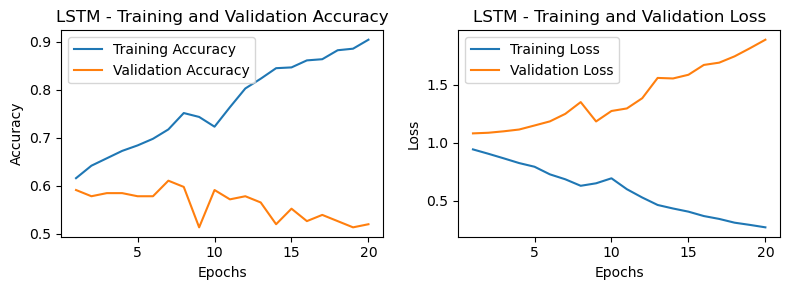

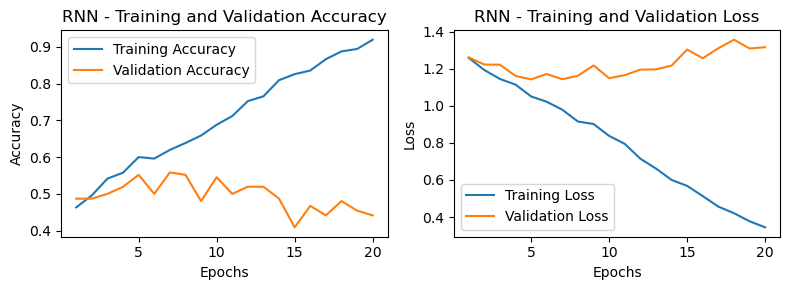

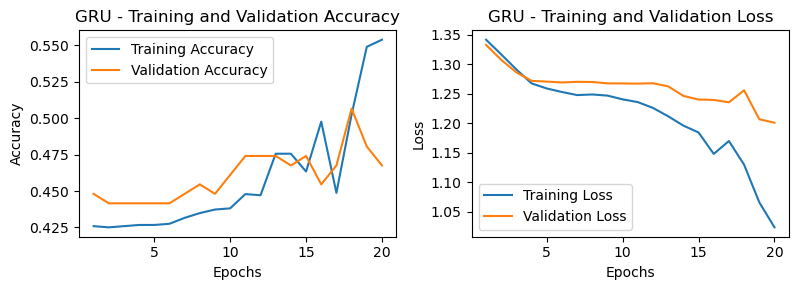

In [26]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_training_history(history, model_name):
    # Extract the accuracy and loss values from the history object
    accuracy = history.history['sparse_categorical_accuracy']
    val_accuracy = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you have the history objects from training your models
plot_training_history(lstm_history, 'LSTM')
plot_training_history(rnn_history, 'RNN')
plot_training_history(gru_history, 'GRU')


In [27]:
# Execute Predictions on develop data no early stopping
save_predictions_true_evidence(lstm_model, dev_padded, dev_data, "dev_predictions_true_evidences_lstm_no_early.json")
save_predictions_true_evidence(rnn_model, dev_padded, dev_data, "dev_predictions_true_evidences_rnn_no_early.json")
save_predictions_true_evidence(gru_model, dev_padded, dev_data, "dev_predictions_true_evidences_gru_no_early.json")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [28]:
print("without early stopping")
print("lstm")
! python eval.py --predictions dev_predictions_true_evidences_lstm_no_early.json --groundtruth data/dev-claims.json
print("\nrnn")
! python eval.py --predictions dev_predictions_true_evidences_rnn_no_early.json --groundtruth data/dev-claims.json
print("\ngru")
! python eval.py --predictions dev_predictions_true_evidences_gru_no_early.json --groundtruth data/dev-claims.json


without early stopping
lstm
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.5194805194805194
Harmonic Mean of F and A          = 0.6837606837606837

rnn
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.44155844155844154
Harmonic Mean of F and A          = 0.6126126126126126

gru
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.4675324675324675
Harmonic Mean of F and A          = 0.6371681415929203


Preidct to majority class

In [29]:
def save_predictions_true_evidence_majority(original_data, output_file):

    predictions_dict = {}

    for i, (claim_id, item) in enumerate(original_data.items()):
        claim_text = item['claim_text']
        true_evidences = item['evidences']
        predictions_dict[claim_id] = {
            "claim_text": claim_text,
            "claim_label": "SUPPORTS",
            "evidences": true_evidences
        }

    with open(output_file, "w") as outfile:
        json.dump(predictions_dict, outfile, indent=2)

# Execute Predictions on develop data 
save_predictions_true_evidence_majority(dev_data, "majority_vote.json")
print("majority_vote")
! python eval.py --predictions majority_vote.json --groundtruth data/dev-claims.json

majority_vote
Evidence Retrieval F-score (F)    = 1.0
Claim Classification Accuracy (A) = 0.44155844155844154
Harmonic Mean of F and A          = 0.6126126126126126


Baseline Result


In [30]:
! python eval.py --predictions data/dev-claims-baseline.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.3377705627705628
Claim Classification Accuracy (A) = 0.35064935064935066
Harmonic Mean of F and A          = 0.3440894901357093
